In [1]:
import os 
import numpy as np
import pandas as pd
from sklearn.naive_bayes import  GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,GridSearchCV,cross_validate
from sklearn.metrics import classification_report,accuracy_score,recall_score,f1_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

In [2]:
# setting working directory 
main_adress = os.path.dirname(os.getcwd())
os.chdir(main_adress + "/Data")

# load the fearures csv
features = pd.read_csv('features.csv')
features = features[features["Date"]<"2020-01-06"]

###  Construct training date set and test data set 

In [3]:
# construct training date set and test data set 
x_train = features[features["Date"]<="2019-03-11"].iloc[:,2:np.shape(features)[1]].values
x_test = features[features["Date"]>"2019-03-11"].iloc[:,2:np.shape(features)[1]].values
y_train = features[features["Date"]<="2019-03-11"].iloc[:,1].values
y_test = features[features["Date"]>"2019-03-11"].iloc[:,1].values

###  Baseline models: LDA, QDA, GBN,LOGISTIC

In [4]:
# non-parameter model 
# LDA
lda_clf = LinearDiscriminantAnalysis().fit(x_train,y_train)

# QDA
qda_clf = QuadraticDiscriminantAnalysis().fit(x_train,y_train)

# GBN
gbn_clf = GaussianNB().fit(x_train,y_train)

# LOGISTIC
lg_clf = LogisticRegression()
lg_selected_clf = RFE(lg_clf,step=1).fit(x_train,y_train)


### Parameter models: SVM, RandomForest

In [5]:
# SVM
param_grid = {'C':[0.001,0.01,0.1,1.0,5,10],'gamma':[0.001,0.01,0.1,1,5,10]}
svm_grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                               cv= KFold(n_splits=5,
random_state=123),n_jobs= -1)
svm_grid_search.fit(x_train,y_train)
print(svm_grid_search.best_params_)

{'C': 1.0, 'gamma': 1}


In [6]:
# fit svm with the best parameters 
svm_clf = SVC(C=1,kernel='rbf',gamma=1).fit(x_train,y_train)

In [7]:
param_grid = {'n_estimators':np.arange(100,1001,100),
               'max_depth': np.arange(1,16,1),
            'max_features':np.arange(1, 15, 2),
              'criterion':['gini','entropy']}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123),param_grid,
                              cv=KFold(n_splits=5,random_state=123), verbose=2, n_jobs=-1)
rf_grid_search.fit(x_train,y_train)
print(rf_grid_search.best_params_)
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 13, 'n_estimators': 100}

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3249 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 4869 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 5800 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 6813 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 7906 tasks     

In [8]:
# fit random forest with the best parameters 
rf_clf = RandomForestClassifier(n_estimators=100,criterion='gini',
                                max_depth=4,max_features=13,random_state=123).fit(x_train,y_train)

In [9]:
# save the model 
os.chdir(main_adress + "/Models_train/models")
my_model = [lda_clf,qda_clf,gbn_clf,lg_selected_clf,svm_clf,rf_clf]
my_model_names = ['LDA.pickle','QDA.pickle','GBN.pickle',
                  'LOGISTIC.pickle','SVM.pickle','RF.pickle']
for i in range(len(my_model_names)):
    with open(my_model_names[i], 'wb') as f:
        pickle.dump(my_model[i], f)

### Predict the market direction

In [10]:
# prediction
y_pred = []
for model in my_model:
    y_pred.append(model.predict(x_test))

In [11]:
from sklearn.metrics import classification_report,accuracy_score,recall_score,f1_score


def model_performance(y_test,y_pred):
    
    res = pd.DataFrame()
    res['accuracy'] = [accuracy_score(y_test,y_pred)]
    res['Down_precision'] = [classification_report(y_test,y_pred,
                                                   output_dict=True)['0']['precision']]
    res['Up_precision'] = [classification_report(y_test,y_pred,output_dict=True)['1']['precision']]
    res['f1_score'] = [f1_score(y_test,y_pred,average='weighted')]
    res['recall_score'] = [recall_score(y_test,y_pred,average='weighted')]
    return res
    

### Models performance 

In [12]:
from sklearn.metrics import classification_report,accuracy_score,recall_score,f1_score

# model performance table 
model_performance_table = model_performance(y_test,y_pred[0])
for i in range(1,len(y_pred)):
    
    model_performance_table = pd.concat([model_performance_table,
                                         model_performance(y_test,y_pred[i])],axis=0)

model_performance_table.index = ['LDA','QDA','GNB','LOGISTIC','SVM','RF']

print(model_performance_table)

          accuracy  Down_precision  Up_precision  f1_score  recall_score
LDA       0.714286        0.714286      0.714286  0.680771      0.714286
QDA       0.619048        0.461538      0.689655  0.612245      0.619048
GNB       0.571429        0.400000      0.666667  0.571429      0.571429
LOGISTIC  0.642857        0.000000      0.642857  0.503106      0.642857
SVM       0.714286        0.714286      0.714286  0.680771      0.714286
RF        0.714286        0.666667      0.727273  0.692857      0.714286


### Cross validation score

In [13]:
# total data
x = features.iloc[:,2:np.shape(features)[1]].values
y = features.iloc[:,1].values

In [14]:
# The best model 
best_model = [LinearDiscriminantAnalysis(),
              QuadraticDiscriminantAnalysis(),
              GaussianNB(),
              RFE(lg_clf,step=1),
              SVC(C=1,kernel='rbf',gamma=1),
              RandomForestClassifier(n_estimators=100,criterion='gini',
                                max_depth=4,max_features=13,random_state=123)
              ]

In [15]:
# The average cross validation accuracy
cv_score = pd.DataFrame()
names = ['LDA','QDA','GNB','LOGISTIC','SVM','RF']
for i in range(len(best_model)):
    cv_result = cross_validate(best_model[i], x_train, y_train, 
                               cv=5,
                               n_jobs=-1,
                               return_train_score=True)
    cv_score[names[i]] = [np.mean(cv_result['test_score'])]
print(cv_score)

       LDA       QDA       GNB  LOGISTIC       SVM        RF
0  0.56631  0.542246  0.518004   0.63262  0.645098  0.621034


### Confusion Matrix

In [16]:
def plot_confusion_matrix(the_pred, 
                          the_true,
                          save_plot=False,
                          the_path=None):
    # generate confusion matrix
    confusion_matrix = metrics.confusion_matrix(the_pred, the_true)
    # generate the plot
    plot_df = pd.DataFrame(confusion_matrix, index=["0", "1"], columns=["0", "1"])
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(plot_df, annot=True, cmap="YlGnBu", fmt="g", ax=ax)
    plt.xticks(rotation=30)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    # if save plot
    if save_plot == True:
        fig.savefig(the_path, dpi=500)
        

/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/LDA.png
/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/QDA.png
/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/GBN.png
/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/LOGISTIC.png
/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/SVM.png
/Users/lihaohang/Desktop/FE-595-Final/Models_train/confusion_matrix/RF.png


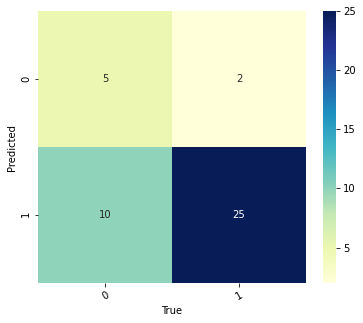

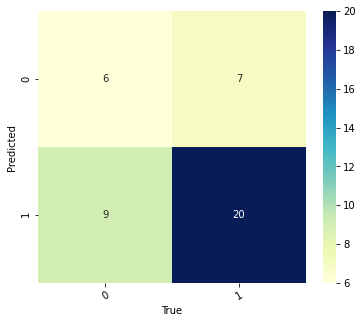

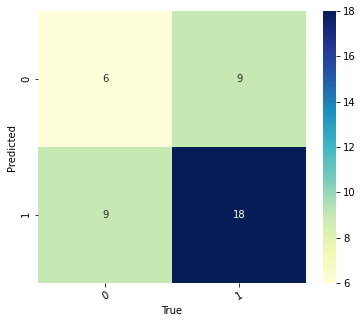

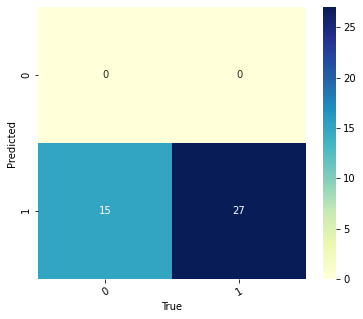

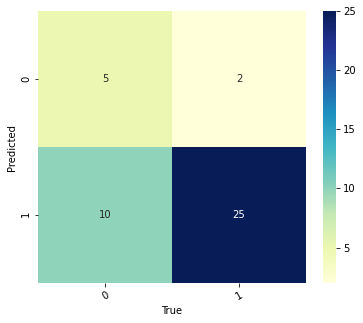

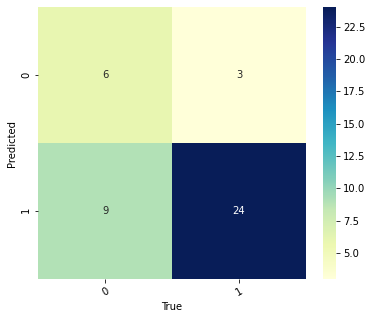

In [17]:
# save the confusion matrix 
cm_names = ['LDA.png','QDA.png','GBN.png','LOGISTIC.png','SVM.png','RF.png']
for i in range(len(cm_names)):
    current_adress = main_adress + "/Models_train/confusion_matrix/" + cm_names[i]
    print(current_adress)
    plot_confusion_matrix(the_pred=y_pred[i],the_true=y_test,
                          save_plot=True,the_path=current_adress)
    

